# The simple 2-bin demo w/ sigmoid activation


![](assets/training.gif)

In [ ]:
import time

import jax
import jax.experimental.optimizers as optimizers
import jax.experimental.stax as stax
import jax.random
from jax.random import PRNGKey
import numpy as np
from functools import partial

import pyhf
pyhf.set_backend('jax')
pyhf.default_backend = pyhf.tensor.jax_backend(precision='64b')

from neos import data, makers, infer

rng = PRNGKey(22)

### Initialise network using `jax.experimental.stax`

In [ ]:
init_random_params, predict = stax.serial(
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(2),
    stax.Softmax,
)

In [ ]:
dgen = data.generate_blobs(rng, blobs=3) 
hmaker = makers.hists_from_nn(dgen, predict                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         , method='softmax')
nnm = makers.hepdata_like_from_hists(hmaker)
get_cls = infer.expected_CLs(nnm, solver_kwargs=dict(pdf_transform=True))

# get_cls returns a list of metrics -- let's just index into the first one (CLs)
def loss(params, test_mu):
    return get_cls(params, test_mu)[0]

### Randomly initialise nn weights and check that we can get the gradient of the loss wrt nn params

In [ ]:
_, network = init_random_params(jax.random.PRNGKey(2), (-1, 2))

# gradient wrt nn weights
jax.value_and_grad(loss)(network, test_mu=1.0)

(DeviceArray(0.07398323, dtype=float64),
 [(DeviceArray([[-0.01394723,  0.00889332, -0.00755367, ..., -0.01692521,
                  0.00212111, -0.01970101],
                [-0.00611163,  0.0067339 , -0.00618019, ..., -0.01004537,
                  0.00136268, -0.01124781]], dtype=float32),
   DeviceArray([ 0.0052404 ,  0.00297238,  0.00319649, ...,  0.00691849,
                -0.00113235, -0.00695833], dtype=float32)),
  (),
  (DeviceArray([[-5.5783303e-06, -4.1947313e-04, -6.2398164e-04, ...,
                 -1.7087770e-03,  1.4778219e-05, -5.8028835e-04],
                [ 1.7306319e-04, -7.9908472e-07,  5.1939214e-04, ...,
                  4.1677014e-04, -1.1140389e-05,  9.1133501e-05],
                [ 1.3320147e-06, -1.7716239e-04, -1.8571694e-04, ...,
                 -7.1186345e-04,  4.9324703e-06, -2.4198412e-04],
                ...,
                [-1.0420149e-05, -7.0664223e-04, -1.0708836e-03, ...,
                 -2.8783218e-03,  2.5193000e-05, -9.7777299e-04],
  

### Define training loop!

In [ ]:
opt_init, opt_update, opt_params = optimizers.adam(1e-3)

def train_network(N):
    cls_vals = []
    _, network = init_random_params(jax.random.PRNGKey(1), (-1, 2))
    state = opt_init(network)
    losses = []

    # parameter update function
    # @jax.jit
    def update_and_value(i, opt_state, mu):
        net = opt_params(opt_state)
        value, grad = jax.value_and_grad(loss)(net, mu)
        return opt_update(i, grad, state), value, net

    for i in range(N):
        start_time = time.time()
        state, value, network = update_and_value(i, state, 1.0)
        epoch_time = time.time() - start_time
        losses.append(value)
        metrics = {"loss": losses}
        yield network, metrics, epoch_time

### Plotting helper function for awesome animations :)

In [ ]:
def plot(axarr, network, metrics, maxN):
    ax = axarr[0]
    g = np.mgrid[-5:5:101j, -5:5:101j]
    levels = np.linspace(0, 1, 21)
    ax.contourf(
        g[0],
        g[1],
        predict(network, np.moveaxis(g, 0, -1)).reshape(101, 101, 2)[:, :, 0],
        levels=levels,
        cmap="BrBG",
    )
    ax.contour(
        g[0],
        g[1],
        predict(network, np.moveaxis(g, 0, -1)).reshape(101, 101, 2)[:, :, 0],
        colors="w",
        levels=levels,
    )

    sig, bkg1, bkg2 = dgen()

    ax.scatter(sig[:, 0], sig[:, 1], alpha=0.25, c="C9", label="sig")
    ax.scatter(bkg1[:, 0], bkg1[:, 1], alpha=0.17, c="C1", label="bkg1")
    ax.scatter(bkg2[:, 0], bkg2[:, 1], alpha=0.17, c="C1", label="bkg2")
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    ax = axarr[1]
    ax.axhline(0.05, c="slategray", linestyle="--")
    ax.plot(metrics["loss"], c="steelblue", linewidth=2.0)

    ax.set_ylim(0, 0.6)
    ax.set_xlim(0, maxN)
    ax.set_xlabel("epoch")
    ax.set_ylabel(r"$cl_s$")

    ax = axarr[2]
    s, b, db = hmaker([network,None])
    ax.bar([0, 1], b, color="C1", label="bkg")
    ax.bar([0, 1], s, bottom=b, color="C9", label="sig")
    ax.bar([0, 1], db, bottom=b - db / 2.0, alpha=0.4, color="black", label="bkg error")
    ax.set_ylim(0, 100)
    ax.set_ylabel("frequency")
    ax.set_xlabel("nn output")

## Install celluloid for animations!

In [ ]:
!python -m pip install celluloid

### Let's run it!!

epoch 0: CLs = 0.0728174959879968, took 1.326793909072876s
epoch 1: CLs = 0.6033747613050151, took 1.3104877471923828s
epoch 2: CLs = 0.4772362510826502, took 1.2828469276428223s
epoch 3: CLs = 0.303203522165707, took 1.248305082321167s
epoch 4: CLs = 0.17807919527972027, took 1.255878210067749s
epoch 5: CLs = 0.09792412166611708, took 1.2482678890228271s
epoch 6: CLs = 0.05045661928240319, took 1.2386081218719482s
epoch 7: CLs = 0.024775323853546416, took 1.2409090995788574s
epoch 8: CLs = 0.012006326372574483, took 1.2387011051177979s
epoch 9: CLs = 0.005995956652717016, took 1.245919942855835s
epoch 10: CLs = 0.003201696644957508, took 1.2547521591186523s
epoch 11: CLs = 0.0018730477806756518, took 1.2674119472503662s
epoch 12: CLs = 0.0012097872459944092, took 1.2580900192260742s
epoch 13: CLs = 0.000855258798814873, took 1.2804017066955566s
epoch 14: CLs = 0.0006508069683333062, took 1.277616024017334s
epoch 15: CLs = 0.0005240430154678233, took 1.283207893371582s
epoch 16: CLs = 

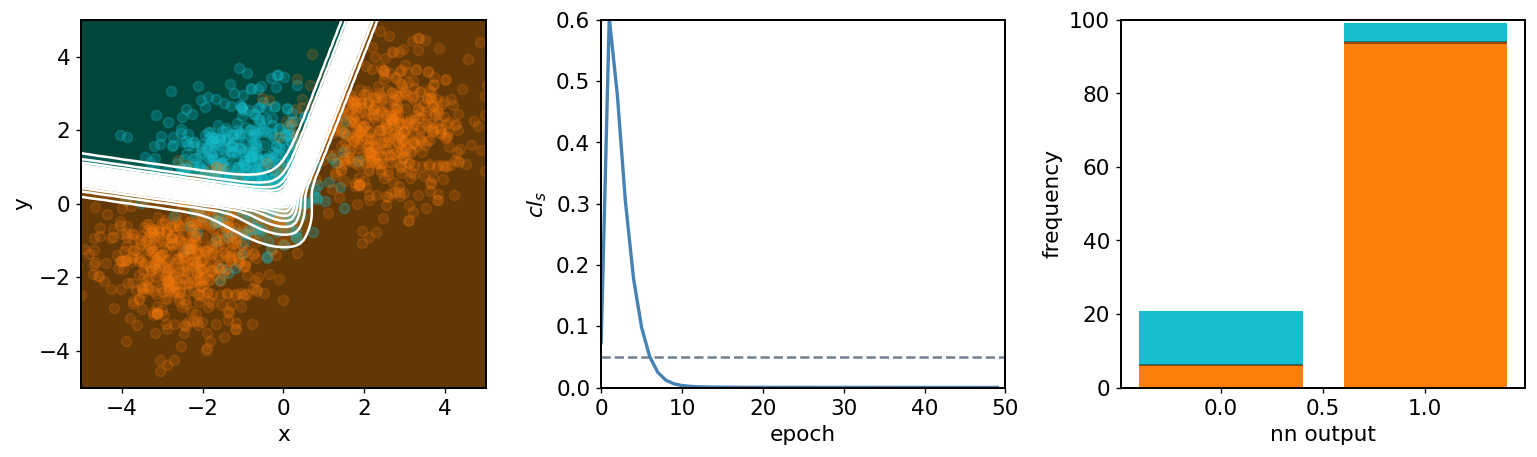

In [ ]:
# slow
import numpy as np
from IPython.display import HTML

from matplotlib import pyplot as plt

plt.rcParams.update(
    {
        "axes.labelsize": 13,
        "axes.linewidth": 1.2,
        "xtick.labelsize": 13,
        "ytick.labelsize": 13,
        "figure.figsize": [13.0, 4.0],
        "font.size": 13,
        "xtick.major.size": 3,
        "ytick.major.size": 3,
        "legend.fontsize": 11,
    }
)


fig, axarr = plt.subplots(1, 3, dpi=120)

maxN = 50  # make me bigger for better results!

animate = True  # animations fail tests...

if animate:
    from celluloid import Camera

    camera = Camera(fig)

# Training
for i, (network, metrics, epoch_time) in enumerate(train_network(maxN)):
    print(f"epoch {i}:", f'CLs = {metrics["loss"][-1]}, took {epoch_time}s')
    if animate:
        plot(axarr, network, metrics, maxN=maxN)
        plt.tight_layout()
        camera.snap()
        if i % 10 == 0:
            camera.animate().save("softmax_animation.gif", writer="imagemagick", fps=8)
            # HTML(camera.animate().to_html5_video())
if animate:
    camera.animate().save("softmax_animation.gif", writer="imagemagick", fps=8)